# Notebook for visualizing consumption data
This notebook is used to visualize the consumption data from Paraguay. It includes code for loading the data, preprocessing it, and creating various plots to analyze the consumption patterns.

#### Print the first few rows

In [1]:
import pandas as pd

# Load the raw consumption data
consumption_path = '../../data/paraguay/electricity-consumption-raw.csv'
df_consumption = pd.read_csv(consumption_path)
df_consumption.head()

,datetime,substation,feeder,consumption
0,2017-01-01T00:00:00,A,A1,NaN
1,2017-01-01T01:00:00,A,A1,58.0
2,2017-01-01T02:00:00,A,A1,58.0
3,2017-01-01T03:00:00,A,A1,58.0
4,2017-01-01T04:00:00,A,A1,52.0


In [2]:
# Identify feeder columns (assuming time columns are first, feeders are the rest)
time_cols = [col for col in df_consumption.columns if 'time' in col.lower() or 'date' in col.lower()]
feeder_cols = [col for col in df_consumption.columns if col not in time_cols]
print(f"Time columns: {time_cols}")
print(f"Feeder columns: {feeder_cols}")
df_consumption[feeder_cols].info()

Time columns: ['datetime']
Feeder columns: ['substation', 'feeder', 'consumption']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1899312 entries, 0 to 1899311
Data columns (total 3 columns):
 #   Column       Dtype  
---  ------       -----  
 0   substation   object 
 1   feeder       object 
 2   consumption  float64
dtypes: float64(1), object(2)
memory usage: 43.5+ MB


In [3]:
# Find the column that contains feeder names (e.g., 'feeder' or similar)
# Let's inspect the columns to find the correct one
print(df_consumption.columns)

# If the feeder column is named 'feeder', get all unique feeders
if 'feeder' in df_consumption.columns:
    unique_feeders = df_consumption['feeder'].unique()
    print(f"Unique feeders: {unique_feeders}")
else:
    print("No 'feeder' column found. Please check the column names above.")

Index(['datetime', 'substation', 'feeder', 'consumption'], dtype='object')
Unique feeders: ['A1' 'A2' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'C1' 'C2' 'D1' 'D2' 'D3' 'E1'
 'E2' 'E3' 'E4' 'E5' 'E6' 'E7' 'F1' 'F2' 'G1' 'G2' 'G3' 'G4' 'H1' 'H2'
 'H3' 'H4' 'H5' 'I1' 'I2' 'I3' 'I4' 'I5' 'J1' 'K1' 'K2' 'K3' 'L1' 'L2'
 'L3' 'L4' 'M1' 'M2' 'M3' 'M4' 'M5' 'M6' 'M7' 'N1' 'N2' 'N3' 'N4']


## Calculate the missing values for each feeder over time

In [4]:
# If the feeder column exists, calculate missing datapoints for each feeder
if 'feeder' in df_consumption.columns:
    feeder_col = 'feeder'
    time_col = time_cols[0] if time_cols else None
    summary = []
    for feeder in df_consumption[feeder_col].unique():
        df_feeder = df_consumption[df_consumption[feeder_col] == feeder]
        n_total = len(df_feeder)
        n_missing = df_feeder.isna().any(axis=1).sum()
        missing_rows = df_feeder[df_feeder.isna().any(axis=1)]
        # Show up to 3 sample missing times
        if time_col:
            sample_missing = missing_rows[time_col].head(3).tolist()
        else:
            sample_missing = missing_rows.index[:3].tolist()
        summary.append({
            'Feeder': feeder,
            'Total Points': n_total,
            'Rows with Missing Data': n_missing,
            'Missing %': round(n_missing / n_total * 100, 2),
            'Sample Missing Times': sample_missing
        })
    summary_df = pd.DataFrame(summary)
    display(summary_df)
else:
    print("No 'feeder' column found. Cannot summarize by feeder.")

,Feeder,Total Points,Rows with Missing Data,Missing %,Sample Missing Times
0,A1,35040,1208,3.45,"[2017-01-01T00:00:00, 2017-01-09T01:00:00, 201..."
1,A2,35040,562,1.60,"[2017-01-01T00:00:00, 2017-01-09T01:00:00, 201..."
2,B1,35040,605,1.73,"[2017-01-01T00:00:00, 2017-01-31T04:00:00, 201..."
3,B2,34944,850,2.43,"[2017-01-01T00:00:00, 2017-01-31T04:00:00, 201..."
4,B3,35040,546,1.56,"[2017-01-01T00:00:00, 2017-01-31T04:00:00, 201..."
5,B4,35040,543,1.55,"[2017-01-01T00:00:00, 2017-02-01T21:00:00, 201..."
6,B5,34560,724,2.09,"[2017-01-01T00:00:00, 2017-02-02T11:00:00, 201..."
7,B6,35040,587,1.68,"[2017-01-01T00:00:00, 2017-02-09T23:00:00, 201..."
8,C1,33720,1137,3.37,"[2017-01-01T00:00:00, 2017-01-24T16:00:00, 201..."
9,C2,33720,1483,4.40,"[2017-01-01T00:00:00, 2017-01-02T22:00:00, 201..."


## Taking into account feeders that might not have data for all timestamps

In [5]:
# Analyze feeder row counts and missing timestamps
if 'feeder' in df_consumption.columns and time_cols:
    feeder_col = 'feeder'
    time_col = time_cols[0]
    # Count how many unique timestamps there are in the whole dataset
    all_timestamps = df_consumption[time_col].unique()
    n_all_timestamps = len(all_timestamps)
    # For each feeder, count how many unique timestamps it has
    feeder_counts = df_consumption.groupby(feeder_col)[time_col].nunique()
    max_rows = feeder_counts.max()
    feeder_with_max = feeder_counts.idxmax()
    print(f"Max rows for a feeder: {max_rows} (Feeder: {feeder_with_max})")
    # For each feeder, calculate how many timestamps are missing
    missing_summary = []
    for feeder, count in feeder_counts.items():
        n_missing = n_all_timestamps - count
        # Find which timestamps are missing for this feeder
        feeder_times = set(df_consumption[df_consumption[feeder_col] == feeder][time_col])
        missing_times = sorted(set(all_timestamps) - feeder_times)
        missing_summary.append({
            'Feeder': feeder,
            'Total Timestamps': count,
            'Missing Timestamps': n_missing,
            'Sample Missing Timestamps': missing_times[:3]
        })
    missing_df = pd.DataFrame(missing_summary)
    display(missing_df)
else:
    print("Required columns not found for this analysis.")

Max rows for a feeder: 35040 (Feeder: A1)


,Feeder,Total Timestamps,Missing Timestamps,Sample Missing Timestamps
0,A1,35040,0,[]
1,A2,35040,0,[]
2,B1,35040,0,[]
3,B2,34944,96,"[2018-04-29T00:00:00, 2018-04-29T01:00:00, 201..."
4,B3,35040,0,[]
5,B4,35040,0,[]
6,B5,34560,480,"[2020-03-21T00:00:00, 2020-03-21T01:00:00, 202..."
7,B6,35040,0,[]
8,C1,33720,1320,"[2020-11-07T00:00:00, 2020-11-07T01:00:00, 202..."
9,C2,33720,1320,"[2020-11-07T00:00:00, 2020-11-07T01:00:00, 202..."


#### Print the start and end of the time range


In [6]:
#Print the start and end of the time range
if time_cols:
    time_col = time_cols[0]
    df_consumption[time_col] = pd.to_datetime(df_consumption[time_col], errors='coerce')
    print(f"Time range: {df_consumption[time_col].min()} to {df_consumption[time_col].max()}")
    print(f"Total timestamps for each feeder: {df_consumption[time_col].nunique()}")
    print(f"Total feeders in dataset: {df_consumption['feeder'].nunique()}")
    print(f"Total substations in dataset: {df_consumption['substation'].nunique()}")


Time range: 2017-01-01 00:00:00 to 2020-12-31 23:00:00
Total timestamps for each feeder: 35040
Total feeders in dataset: 55
Total substations in dataset: 14


#### Visualizing missing data

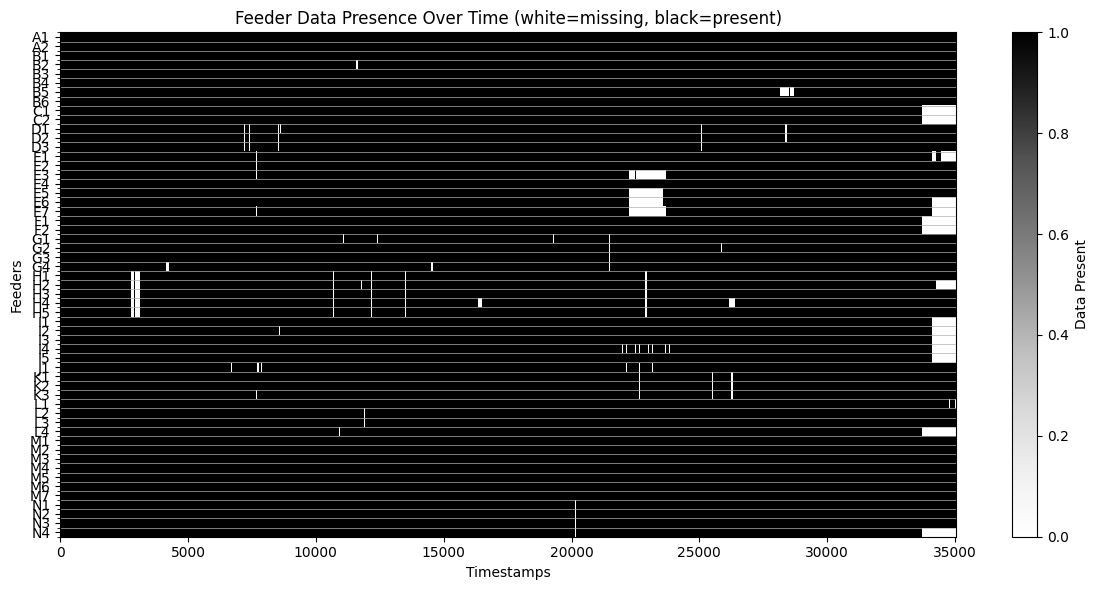

In [ ]:
# Visualize feeder coverage over time
import matplotlib.pyplot as plt
import numpy as np

if 'feeder' in df_consumption.columns and time_cols:
    feeder_col = 'feeder'
    time_col = time_cols[0]
    presence = df_consumption.pivot(index=time_col, columns=feeder_col, values=feeder_col).notna()
    plt.figure(figsize=(12, 6))
    plt.imshow(presence.T, aspect='auto', interpolation='none', cmap='Greys')
    plt.xlabel('Timestamps')
    plt.ylabel('Feeders')
    plt.title('Feeder Data Presence Over Time (white=present, black=missing)')
    # Increase space between feeder names on y-axis
    plt.yticks(np.arange(len(presence.columns)), presence.columns, fontsize=10)
    plt.gca().set_yticks(np.arange(-0.5, len(presence.columns), 1), minor=True)
    plt.gca().yaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
    plt.colorbar(label='Data Present')
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found for this plot.")

### Plot feeders

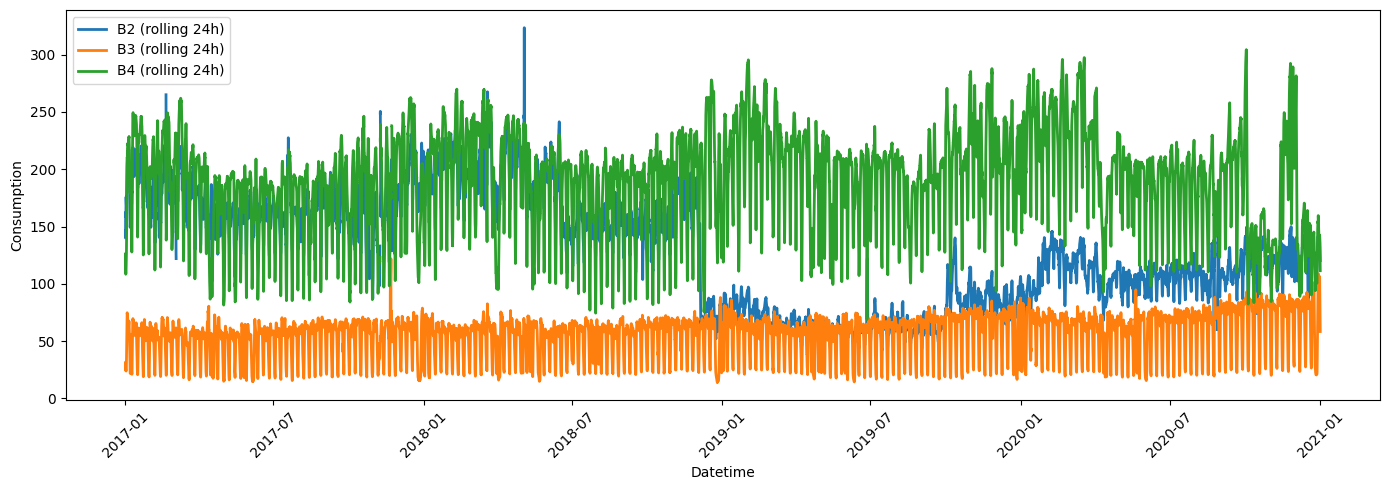

In [51]:
feeders_to_plot = unique_feeders[3:6]  # Plot first 2 feeders for clarity
plt.figure(figsize=(14, 5))
for feeder_name in feeders_to_plot:
    df_f = df_consumption[df_consumption['feeder'] == feeder_name].sort_values('datetime')
    rolling = df_f['consumption'].rolling(window=24, min_periods=1).mean()
    plt.plot(df_f['datetime'], rolling, linestyle='-', linewidth=2, label=f"{feeder_name} (rolling 24h)")

plt.xlabel('Datetime')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


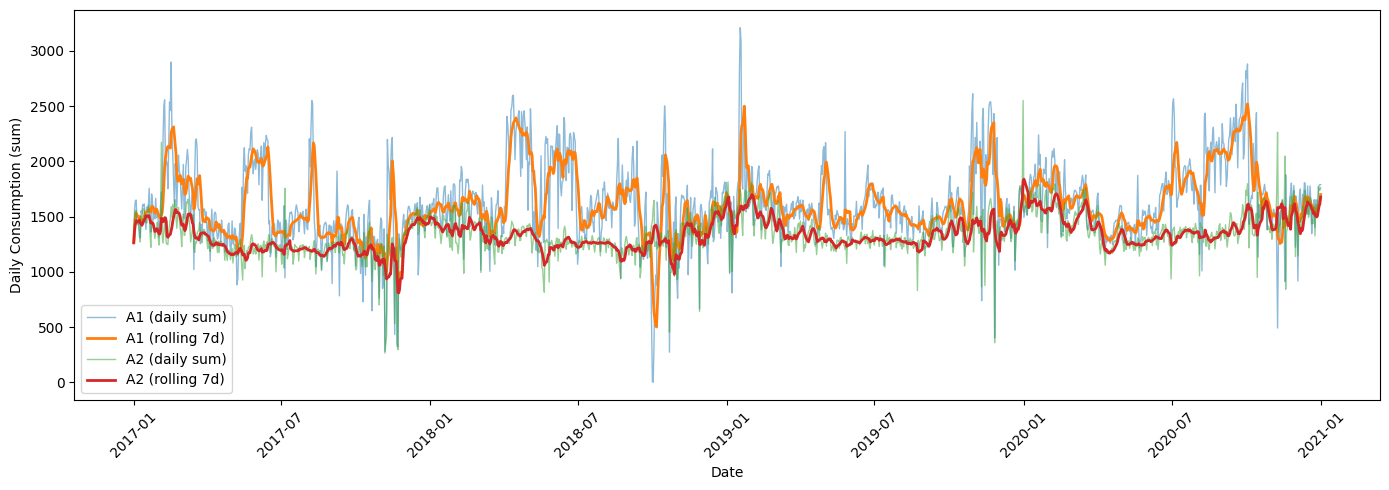

In [40]:
feeders_to_plot = unique_feeders[:2]  # Plot first 2 feeders for clarity
plt.figure(figsize=(14, 5))
window = 7  # 7-day sliding window

for feeder_name in feeders_to_plot:
    df_f = df_consumption[df_consumption['feeder'] == feeder_name].copy()
    # Ensure datetime is datetime type
    df_f['date'] = pd.to_datetime(df_f['datetime']).dt.date
    # Group by date and sum consumption for each day
    daily_sum = df_f.groupby('date')['consumption'].sum()
    # Apply sliding window (rolling mean)
    daily_rolling = daily_sum.rolling(window=window, min_periods=1).mean()
    plt.plot(daily_sum.index, daily_sum.values, linestyle='-', linewidth=1, alpha=0.5, label=f"{feeder_name} (daily sum)")
    plt.plot(daily_rolling.index, daily_rolling.values, linestyle='-', linewidth=2, label=f"{feeder_name} (rolling {window}d)")

plt.xlabel('Date')
plt.ylabel('Daily Consumption (sum)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Detecting Outliers per Feeder
This cell demonstrates how to detect outliers in the consumption data for each feeder using both the IQR (Interquartile Range) and Z-score methods. Outliers are flagged for each feeder separately.

In [33]:
# Detect outliers per feeder using IQR and Z-score methods
from scipy.stats import zscore

# Choose the column names for feeder, consumption, and time
def get_col(colnames, options):
    for opt in options:
        if opt in colnames:
            return opt
    return None

feeder_col = get_col(df_consumption.columns, ['feeder', 'Feeder'])
cons_col = get_col(df_consumption.columns, ['consumption', 'Consumption'])
time_col = time_cols[0] if time_cols else None

if feeder_col and cons_col:
    outlier_results = []
    for feeder, group in df_consumption.groupby(feeder_col):
        # IQR method
        q1 = group[cons_col].quantile(0.25)
        q3 = group[cons_col].quantile(0.75)
        iqr = q3 - q1
        iqr_mask = (group[cons_col] < (q1 - 1.5 * iqr)) | (group[cons_col] > (q3 + 1.5 * iqr))
        iqr_outliers = group[iqr_mask]
        # Z-score method
        zscores = zscore(group[cons_col].dropna())
        z_mask = abs(zscores) > 3
        z_outliers = group.loc[group[cons_col].dropna().index[z_mask]]
        outlier_results.append({
            'Feeder': feeder,
            'IQR Outliers': len(iqr_outliers),
            'Z Outliers': len(z_outliers),
            'Sample IQR Outlier Times': iqr_outliers[time_col].head(3).tolist() if time_col and not iqr_outliers.empty else [],
            'Sample Z Outlier Times': z_outliers[time_col].head(3).tolist() if time_col and not z_outliers.empty else []
        })
    outlier_df = pd.DataFrame(outlier_results)
    display(outlier_df)
else:
    print("Required columns not found for outlier detection.")

,Feeder,IQR Outliers,Z Outliers,Sample IQR Outlier Times,Sample Z Outlier Times
0,A1,1109,381,"[2017-01-16 13:00:00, 2017-02-06 20:00:00, 201...","[2017-02-06 20:00:00, 2017-02-07 20:00:00, 201..."
1,A2,553,96,"[2017-01-03 21:00:00, 2017-01-04 21:00:00, 201...","[2017-01-19 11:00:00, 2017-02-04 16:00:00, 201..."
2,B1,93,90,"[2017-01-16 23:00:00, 2017-03-22 01:00:00, 201...","[2017-01-16 23:00:00, 2017-03-22 01:00:00, 201..."
3,B2,128,72,"[2017-01-12 17:00:00, 2017-01-18 17:00:00, 201...","[2017-02-24 21:00:00, 2017-12-15 17:00:00, 201..."
4,B3,19,20,"[2017-04-12 01:00:00, 2017-06-18 19:00:00, 201...","[2017-04-12 01:00:00, 2017-06-18 19:00:00, 201..."
5,B4,115,79,"[2017-03-22 22:00:00, 2017-05-07 06:00:00, 201...","[2017-03-22 22:00:00, 2017-05-07 06:00:00, 201..."
6,B5,1974,507,"[2017-01-01 01:00:00, 2017-01-01 02:00:00, 201...","[2017-01-02 20:00:00, 2017-01-02 21:00:00, 201..."
7,B6,2310,760,"[2017-02-12 19:00:00, 2017-02-12 20:00:00, 201...","[2017-02-12 19:00:00, 2017-02-12 20:00:00, 201..."
8,C1,258,152,"[2017-01-02 21:00:00, 2017-01-03 21:00:00, 201...","[2017-01-12 20:00:00, 2017-01-12 21:00:00, 201..."
9,C2,523,184,"[2017-01-02 21:00:00, 2017-01-03 06:00:00, 201...","[2017-01-03 20:00:00, 2017-01-04 20:00:00, 201..."


### Plotting Frequency Distribution for Feeder 'A1' with Outlier Boundaries
This cell plots the histogram of the consumption values for feeder 'A1', showing the IQR and Z-score outlier boundaries.

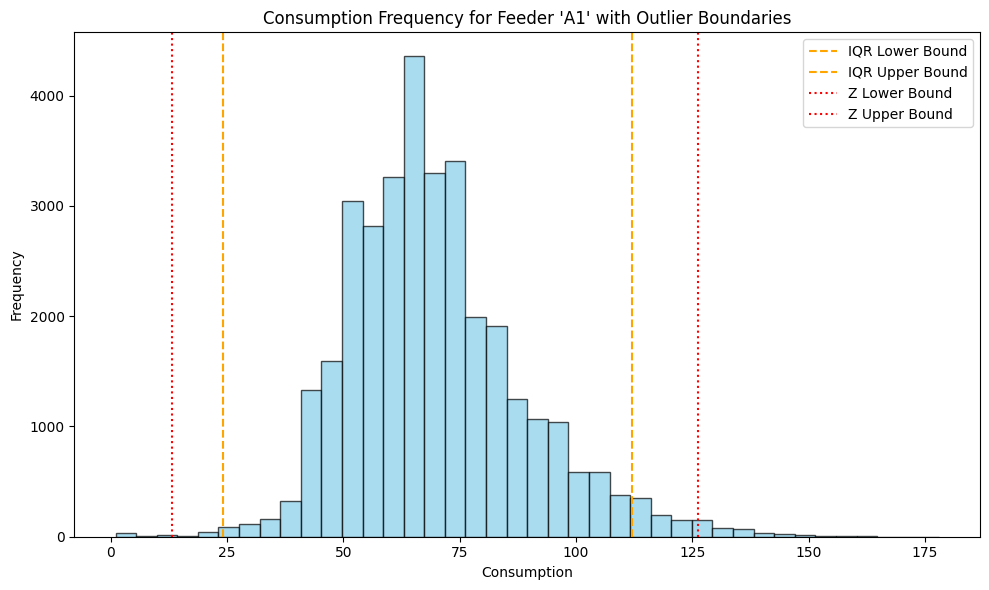

In [28]:
# Plot frequency for A1 feeder with IQR and Z-score boundaries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore

# Find the correct column names
def get_col(colnames, options):
    for opt in options:
        if opt in colnames:
            return opt
    return None

feeder_col = get_col(df_consumption.columns, ['feeder', 'Feeder'])
cons_col = get_col(df_consumption.columns, ['consumption', 'Consumption'])

if feeder_col and cons_col:
    df_a1 = df_consumption[df_consumption[feeder_col] == 'A1']
    values = df_a1[cons_col].dropna()
    # IQR boundaries
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    iqr_low = q1 - 1.5 * iqr
    iqr_high = q3 + 1.5 * iqr
    # Z-score boundaries
    zscores = zscore(values)
    mean = values.mean()
    std = values.std()
    z_low = mean - 3 * std
    z_high = mean + 3 * std
    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=40, color='skyblue', edgecolor='k', alpha=0.7)
    plt.axvline(iqr_low, color='orange', linestyle='--', label='IQR Lower Bound')
    plt.axvline(iqr_high, color='orange', linestyle='--', label='IQR Upper Bound')
    plt.axvline(z_low, color='red', linestyle=':', label='Z Lower Bound')
    plt.axvline(z_high, color='red', linestyle=':', label='Z Upper Bound')
    plt.title("Consumption Frequency for Feeder 'A1' with Outlier Boundaries")
    plt.xlabel('Consumption')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found for plotting.")

### Plotting Feeder Time Series with Outlier Highlighting (IQR and Z-score)
This cell plots the time series for the selected feeders, highlighting outliers detected by both IQR and Z-score methods.

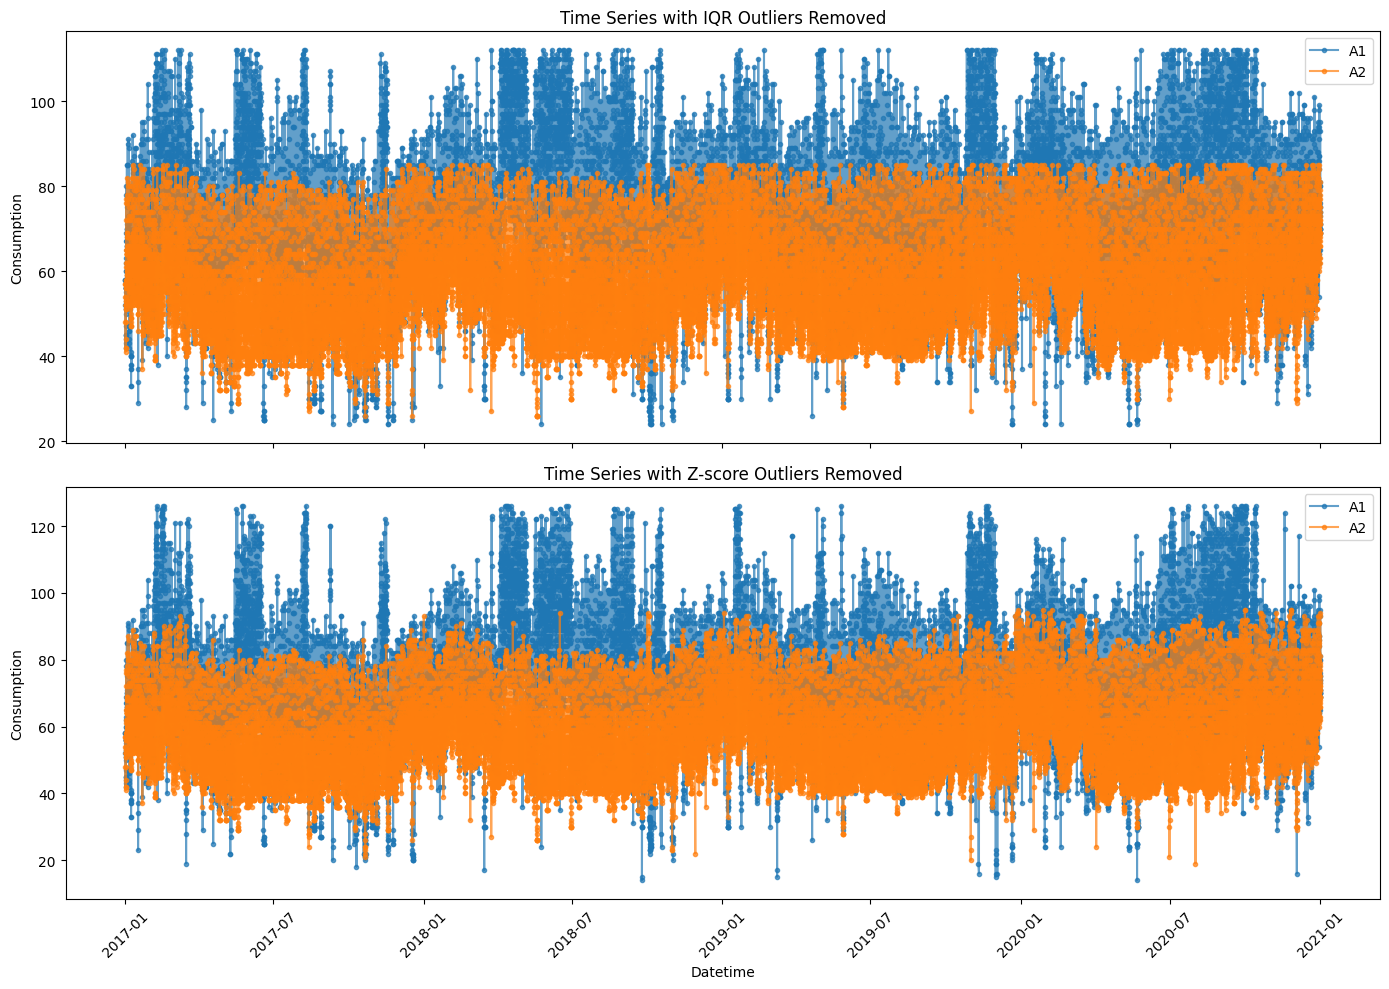

In [41]:
# Remove outliers and plot subplots for both Z-score and IQR methods

# Helper to get column names
def get_col(colnames, options):
    for opt in options:
        if opt in colnames:
            return opt
    return None

feeder_col = get_col(df_consumption.columns, ['feeder', 'Feeder'])
cons_col = get_col(df_consumption.columns, ['consumption', 'Consumption'])
date_col = get_col(df_consumption.columns, ['datetime', 'date', 'time', 'timestamp'])

if feeder_col and cons_col and date_col:
    feeders_to_plot = unique_feeders[:2]
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    for idx, method in enumerate(['IQR', 'Z']):
        for feeder_name in feeders_to_plot:
            df_f = df_consumption[df_consumption[feeder_col] == feeder_name].copy()
            # IQR bounds
            q1 = df_f[cons_col].quantile(0.25)
            q3 = df_f[cons_col].quantile(0.75)
            iqr = q3 - q1
            iqr_low = q1 - 1.5 * iqr
            iqr_high = q3 + 1.5 * iqr
            # Z-score bounds
            mean = df_f[cons_col].mean()
            std = df_f[cons_col].std()
            z_low = mean - 3 * std
            z_high = mean + 3 * std
            if method == 'IQR':
                mask = (df_f[cons_col] >= iqr_low) & (df_f[cons_col] <= iqr_high)
                axes[idx].set_title('Time Series with IQR Outliers Removed')
            else:
                mask = (df_f[cons_col] >= z_low) & (df_f[cons_col] <= z_high)
                axes[idx].set_title('Time Series with Z-score Outliers Removed')
            axes[idx].plot(df_f[date_col][mask], df_f[cons_col][mask], marker='.', linestyle='-', alpha=0.7, label=feeder_name)
        axes[idx].set_ylabel('Consumption')
        axes[idx].legend()
    axes[1].set_xlabel('Datetime')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found for plotting subplots with outliers removed.")


### Plotting Total Consumption per Substation Over Time
This cell groups feeders by their substation, sums the consumption for all feeders connected to each substation at each timestamp, and plots the total consumption for each substation over time.

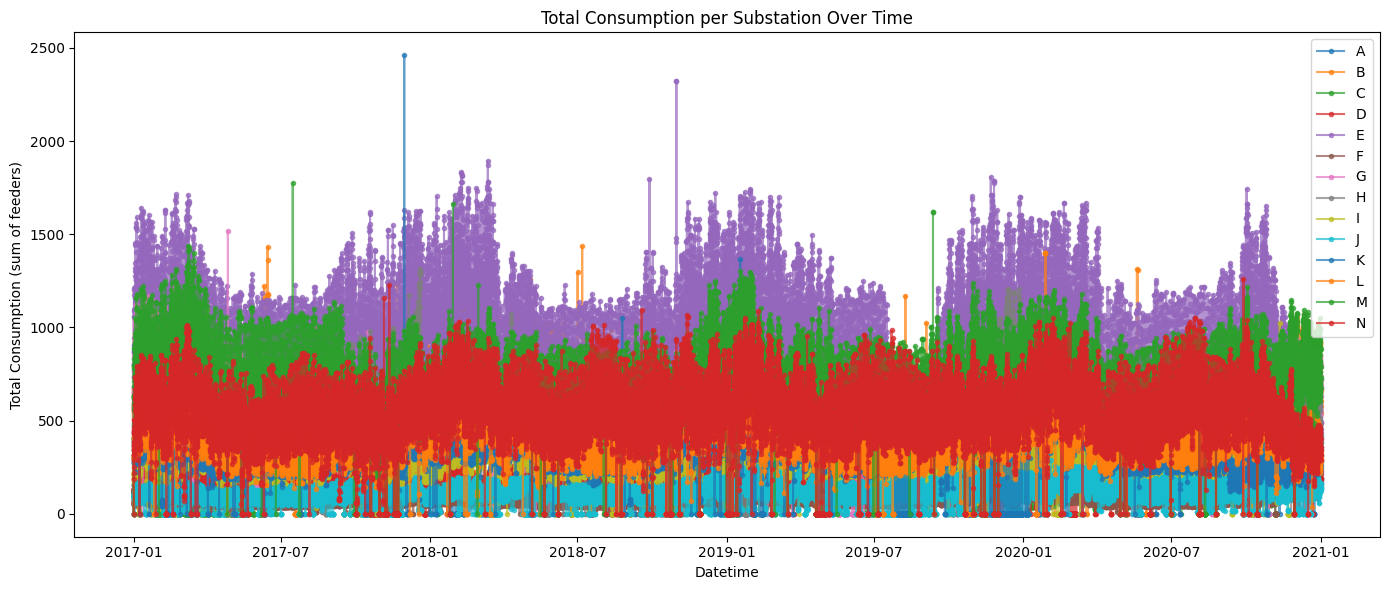

In [42]:
# Sum all feeders per substation and plot over time
import matplotlib.pyplot as plt

# Helper to get column names
def get_col(colnames, options):
    for opt in options:
        if opt in colnames:
            return opt
    return None

substation_col = get_col(df_consumption.columns, ['substation', 'Substation'])
date_col = get_col(df_consumption.columns, ['datetime', 'date', 'time', 'timestamp'])
cons_col = get_col(df_consumption.columns, ['consumption', 'Consumption'])

if substation_col and date_col and cons_col:
    # Ensure datetime is datetime type
    df_consumption[date_col] = pd.to_datetime(df_consumption[date_col], errors='coerce')
    # Group by substation and datetime, sum consumption
    grouped = df_consumption.groupby([substation_col, date_col])[cons_col].sum().reset_index()
    substations = grouped[substation_col].unique()
    plt.figure(figsize=(14, 6))
    for sub in substations:
        df_sub = grouped[grouped[substation_col] == sub]
        plt.plot(df_sub[date_col], df_sub[cons_col], marker='.', linestyle='-', alpha=0.7, label=sub)
    plt.xlabel('Datetime')
    plt.ylabel('Total Consumption (sum of feeders)')
    plt.title('Total Consumption per Substation Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found for substation aggregation plot.")

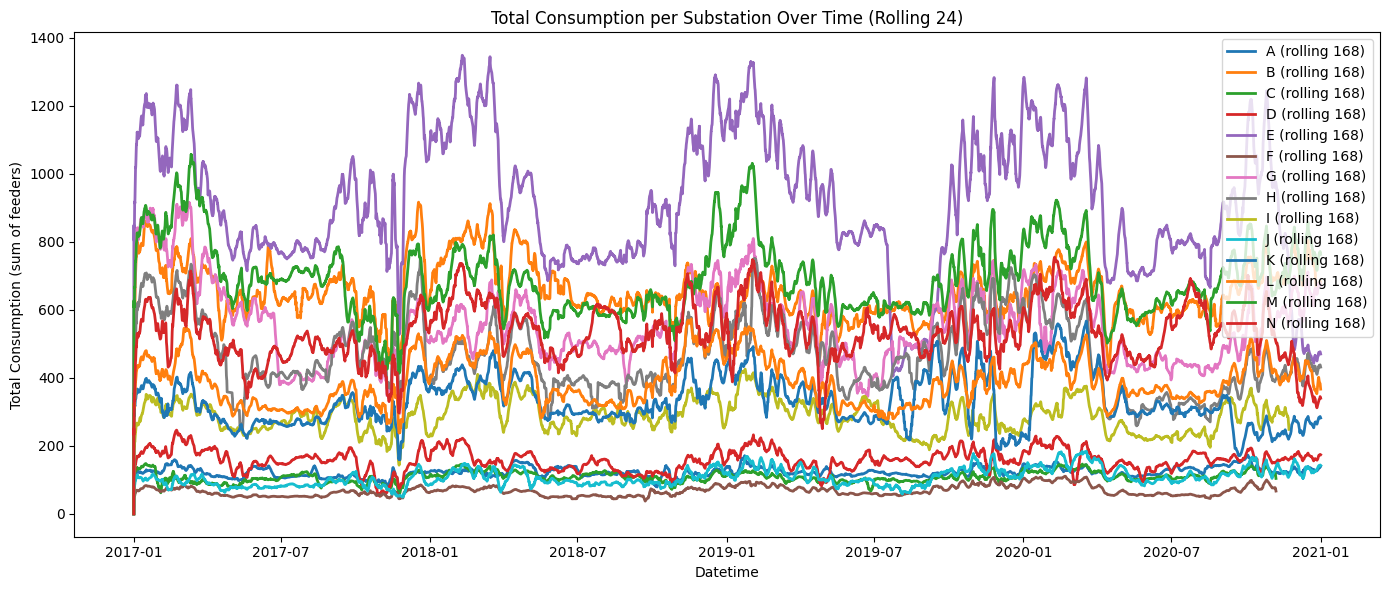

In [44]:
if substation_col and date_col and cons_col:
    df_consumption[date_col] = pd.to_datetime(df_consumption[date_col], errors='coerce')
    grouped = df_consumption.groupby([substation_col, date_col])[cons_col].sum().reset_index()
    substations = grouped[substation_col].unique()
    plt.figure(figsize=(14, 6))
    window = 24*7  # 24-period sliding window
    for sub in substations:
        df_sub = grouped[grouped[substation_col] == sub].sort_values(date_col)
        rolling = df_sub[cons_col].rolling(window=window, min_periods=1).mean()
        plt.plot(df_sub[date_col], rolling, linestyle='-', linewidth=2, label=f"{sub} (rolling {window})")
    plt.xlabel('Datetime')
    plt.ylabel('Total Consumption (sum of feeders)')
    plt.title('Total Consumption per Substation Over Time (Rolling 24)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found for substation aggregation plot.")
